In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
%matplotlib inline
import xgboost as xgb
import statistics
from tensorflow.keras.models import load_model

import fun1
import noniid

2022-08-02 14:55:29.759850: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-02 14:55:29.763185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-02 14:55:29.763198: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def get_avg_output(tr_aki0, extractor):
    tr_x_aki0, tr_y_aki0 = fun1.df_xy(tr_aki0)  
    tr_aki0_output = extractor(tr_x_aki0)
    tr_aki0_output_t = np.array(tr_aki0_output).T
    tr_aki0_output_avg = np.mean(tr_aki0_output_t, axis=1)
    return tr_aki0_output_avg

In [3]:
def final_non_iid(model_nn, tr_df, ts_df):

    extractor = tf.keras.Model(
                inputs = model_nn.inputs, 
                outputs = model_nn.layers[-1].output)
    
    
    tr_output_avg = get_avg_output(tr_df, extractor)   
    ts_output_avg = get_avg_output(ts_df, extractor)

    tr_ts_mean_diff = np.subtract(tr_output_avg, ts_output_avg)
    
    trts_x, trts_y = fun1.df_xy(pd.concat([tr_df, ts_df]))
    trts_output = extractor(trts_x)    
    
    trts_output_std = np.std(np.ravel(trts_output))   
    mean_diff_ratio = tr_ts_mean_diff/trts_output_std
    
    mean_diff_ratio = mean_diff_ratio[
        ~np.isnan(mean_diff_ratio)]    
    
    mean_diff_ratio = mean_diff_ratio[
        ~(mean_diff_ratio == float('-inf'))]
    
    mean_diff_ratio = mean_diff_ratio[
        ~(mean_diff_ratio == float('+inf'))]      
    
    ori_points = np.zeros(len(mean_diff_ratio))
    non_iid = np.linalg.norm(
            mean_diff_ratio - ori_points)
    
    return non_iid    

In [4]:
path = '/home/ai03/_kunyi/pro_shae/datasets/aki_prediction_m4_m3_eicu/'
input_folder = '6tw_6ts_6pre_v1/'
input_dir = path+input_folder

In [5]:
path2 = '/home/ai03/_kunyi/pro_shae/fed_aki_9/'
input_folder2 = 'compute_nonIID_1_Compare_different_methods_Relation_of_nonIID_acc_1_random_weight_init/predict_6hr_trained_models/'
model_dir = path2+input_folder2

In [6]:
k = 5
sampling_value_ls = list(range(100, 0, -10))
model_types = 'nn'
encoder_data_name = 'e_0.4'

In [7]:
plot_d1 = 'MIMIC-III'
d1 = 'm3'
d2 = 'm4'
d3 = 'e_0.6'

In [8]:
def plot_non_iid(d1, d2, d3, plot_d1, 
                 encoder_data_name):
    start_time = time.time()

    model_nn = load_model(
        model_dir+"{}_im_{}.h5".format(
            encoder_data_name, model_types)) 

    df_d1 = pd.read_csv(
        input_dir+"6hr_{}_commonFs.csv".format(d1))

    df_d2 = pd.read_csv(
        input_dir+"6hr_{}_commonFs.csv".format(d2))

    df_d3 = pd.read_csv(
        input_dir +"6hr_{}_commonFs.csv".format(d3))

    df_cols = df_d1.columns.tolist()
    cat_f_ls = df_cols[4:6]
    for i in cat_f_ls:
        df_d1[i] = df_d1[i].astype('category').cat.codes
        df_d2[i] = df_d2[i].astype('category').cat.codes
        df_d3[i] = df_d3[i].astype('category').cat.codes

    noniid_ls_trans_ls = []
    y_value_ls = []

    for s_v in sampling_value_ls:
        print('Sampling {}%'.format(s_v))
        s_v2 = s_v*0.01
        noniid_ls = []   

        for r_i in range(1, k+1):    
            print('Round {}'.format(r_i))
            y_value_ls.append(s_v)

            df2_d1 = df_d1.sample(frac=s_v2, replace=False)
            df2_d2 = df_d2.sample(frac=s_v2, replace=False)
            df2_d3 = df_d3.sample(frac=s_v2, replace=False)
            df_d1d2 = pd.concat([df2_d1, df2_d2])
            df_d1d3 = pd.concat([df2_d1, df2_d3])   

            d1_non_iid = final_non_iid(
                model_nn, df2_d1, df2_d1)    
            d2_non_iid = final_non_iid(
                model_nn, df2_d1, df2_d2)        
            d3_non_iid = final_non_iid(
                model_nn, df2_d1, df2_d3) 
            d1d2_non_iid = final_non_iid(
                model_nn, df2_d1, df_d1d2) 
            d1d3_non_iid = final_non_iid(
                model_nn, df2_d1, df_d1d3)

            all_dfs_non_iid_ls = [d1_non_iid, d2_non_iid, 
                                  d3_non_iid, d1d2_non_iid, 
                                  d1d3_non_iid]
            noniid_ls.append(all_dfs_non_iid_ls)

        noniid_ls_trans = np.array(noniid_ls).T
        noniid_ls_trans_ls.append(noniid_ls_trans)

    temp_ls = noniid_ls_trans_ls
    all_dfs_ls = []

    for df_i in range(0, len(all_dfs_non_iid_ls)):
        one_df_temp_ls = []

        for ls_i in range(0, len(sampling_value_ls)):
            one_df_temp_ls.append(temp_ls[ls_i][df_i])
            one_df_temp_ls_1d = np.concatenate(one_df_temp_ls)

        all_dfs_ls.append(one_df_temp_ls_1d)

    ax = plt.gca()
    ax.set_ylim([0, 105])
    # ax.set_xlim([-0.05, 1.05])
    # plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 101, 10))

    plt.plot(all_dfs_ls[0], y_value_ls, 
             'ko', label='{}'.format(d1))
    plt.plot(all_dfs_ls[1], y_value_ls, 
             'ro', label='{}'.format(d2))
    plt.plot(all_dfs_ls[2], y_value_ls, 
             'yo', label='{}'.format(d3))
    plt.plot(all_dfs_ls[3], y_value_ls, 
             'co', label='{} + {}'.format(d1, d2))
    plt.plot(all_dfs_ls[4], y_value_ls, 
             'go', label='{} + {}'.format(d1, d3))
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

    end_time = time.time()
    elapsed_imte = (end_time - start_time)/60

    t_str1 = 'Fixed Encoder Method \n Non-IIDs of {} Dataset\n'.format(plot_d1)
    plt.title(t_str1+'(computational time {:0.1f} min.): \n predicts next 6hr. AKI'.format(
        elapsed_imte), fontsize=15)
    plt.ylabel('Data Sampling Percentage', fontsize=15)
    plt.xlabel('Non-IID Degree', fontsize=15)
    plt.savefig("QM3_{}_pre6hr".format(
        plot_d1), bbox_inches='tight')
    plt.show()

In [1]:
def get_df2(d1, d2, d3, m3_all_dfs_ls, m3_y_value_ls, elapsed_imte):
    x, y = '_x', '_y'
    df_ts1 = pd.DataFrame(columns=[d1+x, d1+y, 
                                   d2+x, d2+y, 
                                   d3+x, d3+y, 
                                   d1+'+'+d2+x, d1+'+'+d2+y, 
                                   d1+'+'+d3+x, d1+'+'+d3+y])
    df_ts2 = df_ts1.copy()
    for xi, li in zip(range(0, 9, 2), range(0,5)):
        df_ts2[df_ts2.columns.tolist()[xi]] = m3_all_dfs_ls[li]
        df_ts2[df_ts2.columns.tolist()[xi+1]] = m3_y_value_ls
    df_ts2.to_csv("M3_{}_time_{:0.1f}_non_iid_fig4.csv".format(
        d1, elapsed_imte), index=False)   
    return df_ts2

2022-08-02 14:55:30.856611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-02 14:55:30.856710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-02 14:55:30.856773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-02 14:55:30.859090: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-08-02 14:55:30.859161: W tensorflow/stream_executor/platform/default/dso_loader

Sampling 100%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 90%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 80%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 70%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 60%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 50%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 40%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 30%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 20%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 10%
Round 1
Round 2
Round 3
Round 4
Round 5


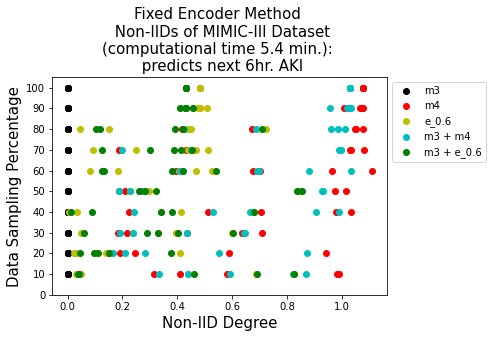

In [9]:
plot_d1 = 'MIMIC-III'
d1 = 'm3'
d2 = 'm4'
d3 = 'e_0.6'
plot_non_iid(d1, d2, d3, plot_d1, 
             encoder_data_name)

Sampling 100%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 90%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 80%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 70%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 60%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 50%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 40%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 30%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 20%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 10%
Round 1
Round 2
Round 3
Round 4
Round 5


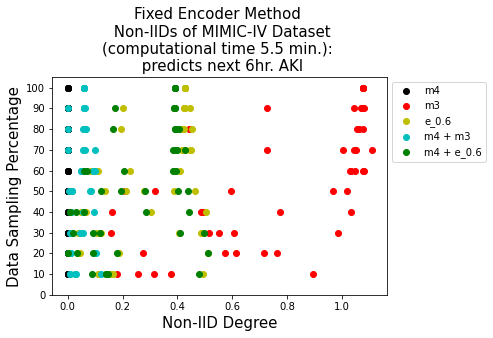

In [10]:
plot_d1 = 'MIMIC-IV'
d1 = 'm4'
d2 = 'm3'
d3 = 'e_0.6'
plot_non_iid(d1, d2, d3, plot_d1, 
             encoder_data_name)

In [2]:
m4_df2 = get_df2(d1, d2, d3, 
                 m4_all_dfs_ls, m4_y_value_ls, m4_t)
m4_df2

NameError: name 'd1' is not defined

Sampling 100%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 90%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 80%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 70%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 60%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 50%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 40%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 30%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 20%
Round 1
Round 2
Round 3
Round 4
Round 5
Sampling 10%
Round 1
Round 2
Round 3
Round 4
Round 5


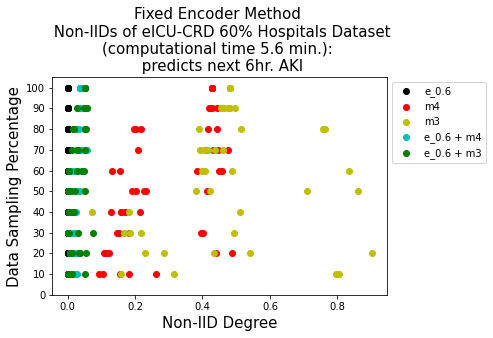

In [11]:
plot_d1 = 'eICU-CRD 60% Hospitals'
d1 = 'e_0.6'
d2 = 'm4'
d3 = 'm3'
plot_non_iid(d1, d2, d3, plot_d1, 
             encoder_data_name)